<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Adiabatic-evolution,-for-reference" data-toc-modified-id="Adiabatic-evolution,-for-reference-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Adiabatic evolution, for reference</a></span></li><li><span><a href="#Old-bangramp-calculations" data-toc-modified-id="Old-bangramp-calculations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Old bangramp calculations</a></span><ul class="toc-item"><li><span><a href="#Search-for-locally-optimal-path" data-toc-modified-id="Search-for-locally-optimal-path-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Search for locally optimal path</a></span></li></ul></li><li><span><a href="#Optimizations-0217" data-toc-modified-id="Optimizations-0217-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Optimizations 0217</a></span></li><li><span><a href="#Optimizations-0227" data-toc-modified-id="Optimizations-0227-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Optimizations 0227</a></span></li><li><span><a href="#Optimizations-0228" data-toc-modified-id="Optimizations-0228-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Optimizations 0228</a></span><ul class="toc-item"><li><span><a href="#What-happens-for-different-boundaries?" data-toc-modified-id="What-happens-for-different-boundaries?-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>What happens for different boundaries?</a></span></li><li><span><a href="#And-changing-the-number-of-spins-in-the-LMG?" data-toc-modified-id="And-changing-the-number-of-spins-in-the-LMG?-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>And changing the number of spins in the LMG?</a></span></li></ul></li><li><span><a href="#LMG-optimizations-crossing-the-critical-point" data-toc-modified-id="LMG-optimizations-crossing-the-critical-point-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>LMG optimizations crossing the critical point</a></span><ul class="toc-item"><li><span><a href="#$50$-spins" data-toc-modified-id="$50$-spins-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>$50$ spins</a></span></li><li><span><a href="#$20$-spins" data-toc-modified-id="$20$-spins-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>$20$ spins</a></span></li><li><span><a href="#Using-as-target-$g=1.5$-instead-of-$g=2$" data-toc-modified-id="Using-as-target-$g=1.5$-instead-of-$g=2$-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Using as target $g=1.5$ instead of $g=2$</a></span></li></ul></li><li><span><a href="#Rabi-crossing-critical-point" data-toc-modified-id="Rabi-crossing-critical-point-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Rabi crossing critical point</a></span></li><li><span><a href="#Triplebang" data-toc-modified-id="Triplebang-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Triplebang</a></span></li><li><span><a href="#LMG-doublebang-scans" data-toc-modified-id="LMG-doublebang-scans-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>LMG doublebang scans</a></span></li><li><span><a href="#LMG,-doublebang,-optimal-time-VS-number-of-spins" data-toc-modified-id="LMG,-doublebang,-optimal-time-VS-number-of-spins-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>LMG, doublebang, optimal time VS number of spins</a></span></li><li><span><a href="#Landau-Zener-tests" data-toc-modified-id="Landau-Zener-tests-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Landau-Zener tests</a></span></li></ul></div>

In [1]:
import datetime
import logging
import os
import pickle
import sys
import time
import functools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()
import progressbar
import qutip
#QuTiP control modules
import qutip.control.pulseoptim as cpo
import qutip.logging_utils
import scipy
import seaborn as sns

if './src/' not in sys.path:
    sys.path.append('./src/')
import rabi_model
import lmg_model
import lz_model
import optimization
import protocol_ansatz
import hamiltonians
from utils import ground_state

sns.set()

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Adiabatic evolution, for reference

Test with adiabatic evolution. Plot of fidelity between final state and critical gs for various times. It is evident that good fidelities require very long times.

100% (40 of 40) |########################| Elapsed Time: 0:00:20 Time:  0:00:20


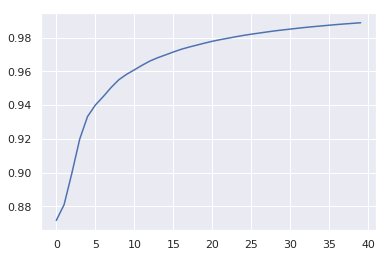

In [143]:
# set where to truncate Fock state
N = 100
# set constant coefficients
Omega = N
omega_0 = 1.
lambda_c = np.sqrt(Omega * omega_0) / 2. # critical coefficient
# initial and target hamiltonians
initial_hamiltonian = rabi_model.QRM_free_term(N, Omega, omega_0)
final_hamiltonian = rabi_model.QRM_full(N, Omega, omega_0, lambda_c)
# times and settings
times_to_try = np.arange(0, 40)
target_state = ground_state(final_hamiltonian)
results = []
bar = progressbar.ProgressBar()
for tf in bar(times_to_try):
    final_state = optimization.evolve_adiabatically(initial_hamiltonian, final_hamiltonian, tf)
    results.append(qutip.fidelity(final_state, target_state))

plt.figure()
plt.plot(times_to_try, results)

# Old bangramp calculations

See what happens when the second ramp is removed. The protocol thus becomes two constant ramps, and the parameters to optimize are their heights and the the time at which the first becomes the second one.

In [220]:
def _():
    # load data
    bangrampAndAdiabatic_df = pd.read_csv('rabi_Omega100_bangrampOptimizedWithNelderMead+adiabatic.csv', index_col=0)
    bangrampNoRamp_df = pd.read_csv('rabi_Omega100_bangrampWithoutRampOptimizedWithNelderMead.csv', index_col=0)
    bangrampNoRampPowell_df = pd.read_csv('rabi_Omega100_bangrampWithoutRampOptimizedWithPowell.csv', index_col=0)
    crab_df = pd.read_csv('rabi_Omega100_crab_2frequencies.csv', index_col=0)
    # plot
    traces = [
        go.Scatter(
            x=bangrampAndAdiabatic_df['tf'], y=bangrampAndAdiabatic_df['adiabatic_fid'],
            mode='lines+markers', name='adiabatic'
        ),
        go.Scatter(
            x=bangrampAndAdiabatic_df['tf'], y=bangrampAndAdiabatic_df['fid'],
            mode='lines+markers', name='optim bang-ramp, NM'
        ),
        go.Scatter(
            x=bangrampNoRamp_df['tf'], y=bangrampNoRamp_df['fid'],
            mode='lines+markers', name='optim double bang, NM'
        ),
        go.Scatter(
            x=bangrampNoRampPowell_df['tf'], y=bangrampNoRampPowell_df['fid'],
            mode='lines+markers', name='optim double bang, Powell'
        ),
        go.Scatter(
            x=crab_df['tf'], y=crab_df['fid'],
            mode='lines+markers', name='crab, NM'
        )
    ]
    plotly.offline.iplot(traces)
_()

## Search for locally optimal path

Starting from some starting point, at every step we here look for the next value of the parameter that gives us the maximum fidelity, and follow such path.

100% (50 of 50) |########################| Elapsed Time: 0:00:28 Time:  0:00:28


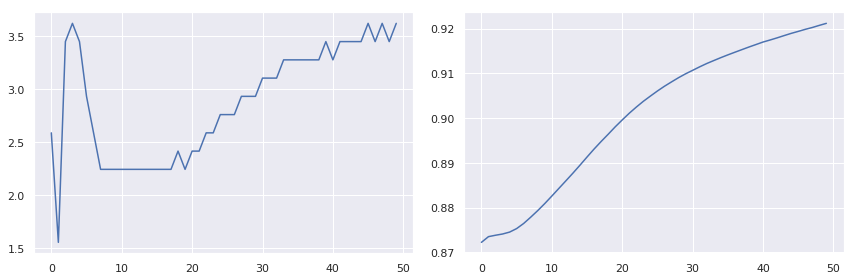

In [53]:
def _():
    N = 100
    Omega = N
    omega_0 = 1.
    # build Hamiltonian
    lambda_c = np.sqrt(Omega * omega_0) / 2. # critical coefficient
    H0 = rabi_model.QRM_free_term(N, Omega, omega_0)
    H1 = rabi_model.QRM_interaction_term(N)

    # compute initial and target states
    psi_initial = rabi_model.ground_state(H0)
    psi_target = rabi_model.ground_state(H0 + lambda_c * H1)
    psi_current = psi_initial

    dt = 0.05
    number_of_steps = 50
    lambdas_to_try = np.linspace(0, 5, 30)
    all_lambdas = np.zeros(number_of_steps)
    all_fidelities = np.zeros(number_of_steps)
    
    bar = progressbar.ProgressBar()
    for step_number in bar(range(number_of_steps)):
        
        results_arr = np.zeros_like(lambdas_to_try)
        states_arr = [0] * len(results_arr)
        for idx, lambda_ in enumerate(lambdas_to_try):
            H = H0 + lambda_ * H1
            times_list = np.linspace(0, dt, 10)
            output_state = qutip.mesolve(H, psi_current, tlist=times_list)
            states_arr[idx] = output_state.states[-1]
            results_arr[idx] = qutip.fidelity(psi_target, output_state.states[-1])
        max_fidelity_index = np.argmax(results_arr)
        all_lambdas[step_number] = lambdas_to_try[max_fidelity_index]
        all_fidelities[step_number] = results_arr[max_fidelity_index]
#         print('Fidelity at step {:3}: {:2.3f}, lambda: {:2.3f}'.format(
#             step_number, results_arr[max_fidelity_index], lambdas_to_try[max_fidelity_index]))
        psi_current = states_arr[max_fidelity_index]
    # run the actual optimisation
    return (all_lambdas, all_fidelities)
out = _()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(out[0])
ax[1].plot(out[1])
plt.tight_layout()

100% (40 of 40) |########################| Elapsed Time: 0:02:03 Time:  0:02:03
100% (1 of 1) |##########################| Elapsed Time: 0:02:03 Time:  0:02:03


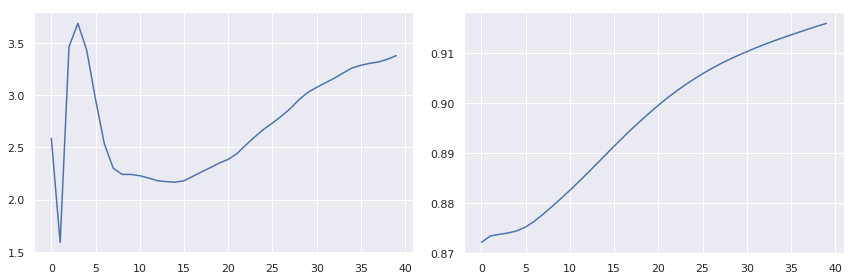

In [210]:
def rabi_locally_optimal_path_search(
    N=100, psi_initial=None, psi_target=None, dt=0.01, number_of_steps=200,
    optimization_method='Powell', save_results_to_file=True
):
    """Search for the locally optimal path in parameter space.
    
    Parameters
    ----------
    N : int
        Dimension of the Fock space
    psi_initial : qutip.Qobj, optional
        Initial state. If omitted defaults to the noninteracting ground state.
    psi_target : qutip.Qobj, optional
        State that we want to obtain.
        If omitted defaults to ground state at the critical point.
    dt : float
        The optimized path is piecewise constant, with dt length of constant phases.
    number_of_steps : int
        How many constant steps, and thus optimizations, are performed.
    optimization_method : str
        How the local optimization is performed.
        Accepted values: 'Powell'.
    """
    Omega = N
    omega_0 = 1.
    # build Hamiltonian
    lambda_c = np.sqrt(Omega * omega_0) / 2. # critical coefficient
    H0 = rabi_model.QRM_free_term(N, Omega, omega_0)
    H1 = rabi_model.QRM_interaction_term(N)
    store_file_name = 'locally_optimal_search_results.hdf5'

    # compute initial and target states
    if psi_initial is None:
        psi_initial = rabi_model.ground_state(H0)
    if psi_target is None:
        psi_target = rabi_model.ground_state(H0 + lambda_c * H1)
    psi_current = psi_initial

    # lambdas_to_try = np.linspace(0, 5, 30)
    all_lambdas = np.zeros(number_of_steps)  # will store obtained lambdas
    all_fidelities = np.zeros(number_of_steps)  # will store obtained fidelities
    
    bar = progressbar.ProgressBar()
    for step_number in bar(range(number_of_steps)):
        def cost(lambda_, *args):
            lambda_ = lambda_[0]
            H = H0 + lambda_ * H1
            times_list = np.linspace(0, dt, 30)
            output_state = qutip.mesolve(H, psi_current, tlist=times_list)
            return 1 - qutip.fidelity(psi_target, output_state.states[-1])
        out_lambda = scipy.optimize.minimize(cost, x0=[6], method='Powell').x
        out_lambda = float(out_lambda)
        all_lambdas[step_number] = out_lambda
        # recompute locally optimal output
        H = H0 + out_lambda * H1
        output_state = qutip.mesolve(H, psi_current, tlist=np.linspace(0, dt, 10)).states[-1]
        all_fidelities[step_number] = qutip.fidelity(psi_target, output_state)
#         print('Fidelity at step {:3}: {:2.3f}, lambda: {:2.3f}'.format(
#             step_number, results_arr[max_fidelity_index], lambdas_to_try[max_fidelity_index]))
        psi_current = output_state
    # save results to file
    if save_results_to_file:
        with h5py.File(store_file_name, 'a') as f:
            timestr = time.strftime("%m%d-%H%M%S")
            dset = f.create_dataset(timestr, data=np.asarray([all_lambdas, all_fidelities]))
            dset.attrs['dt'] = dt
            dset.attrs['number_of_steps'] = number_of_steps
            dset.attrs['N'] = N
            dset.attrs['optimization_method'] = optimization_method
    # return results (unnecessary if saving to file)
    return (all_lambdas, all_fidelities)

total_time = 2
bar = progressbar.ProgressBar()
for num_divisions in bar([40]):
    out = rabi_locally_optimal_path_search(N=100, dt=total_time / num_divisions,
                                           number_of_steps=num_divisions,
                                           save_results_to_file=False)
#     print(print_hdf5_store_content('locally_optimal_search_results.hdf5'))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(out[0])
ax[1].plot(out[1])
plt.tight_layout()

100% (2 of 2) |##########################| Elapsed Time: 0:00:11 Time:  0:00:11


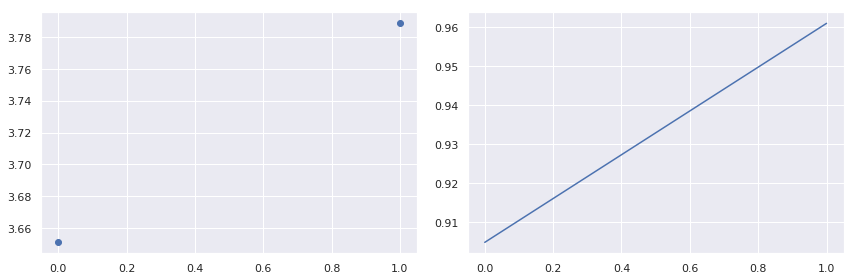

In [213]:
total_time = 2
num_divisions = 2
out = rabi_locally_optimal_path_search(N=100, dt=total_time / num_divisions,
                                       number_of_steps=num_divisions,
                                       save_results_to_file=False)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(out[0], 'o')
ax[1].plot(out[1])
plt.tight_layout()

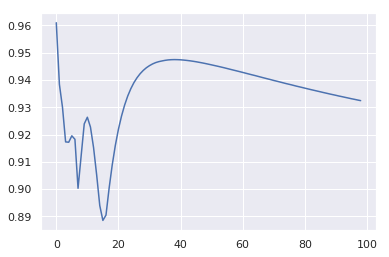

In [203]:
filename = 'locally_optimal_search_results.hdf5'
with h5py.File(filename, 'r') as f:
    keys = list(f.keys())
    fidelities = np.zeros(len(keys))
    for idx, key in enumerate(keys):
        fidelities[idx] = f[key][1, -1]
plt.figure()
plt.plot(fidelities)

In [209]:
filename = 'locally_optimal_search_results.hdf5'
with h5py.File(filename, 'r') as f:
    keys = list(f.keys())
    print(f[keys[0]][:])

[[3.65100698 3.7886232 ]
 [0.90475631 0.96096745]]


In [ ]:
def print_hdf5_store_content(filename):
    with h5py.File(filename, 'r') as f:
        content = list(f.keys())
        return content
# print_hdf5_store_content('locally_optimal_search_results.hdf5')

# Optimizations 0217

In [336]:
def _():
    # load data
    datafiles = !ls ./results/rabi_20190217/rabi*.csv
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=df['fid'],
            mode='lines+markers', name=os.path.split(file)[-1]
        ))
    layout = go.Layout(legend=dict(x=.7, y=0))
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
_()

In [337]:
def _():
    # load data
    datafiles = !ls ./results/rabi_20190217/lmg*.csv
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=df['fid'],
            mode='lines+markers', name=os.path.split(file)[-1]
        ))
    layout = go.Layout(legend=dict(x=.7, y=0))
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
_()

In [320]:
# 3.015152	0.995751	4.396702
N = 100
Omega = 100
omega_0 = 1
lambda_c = np.sqrt(Omega * omega_0) / 2.
# build Hamiltonians
H0 = rabi_model.QRM_free_term(N, Omega, omega_0)
H1 = rabi_model.QRM_interaction_term(N)
# compute initial and target states
target_state = ground_state(H0 + lambda_c * H1)
# let's try here using random initial parameters
final_state = optimization.evolve_state(
    hamiltonian=H0 + 4.3967 * H1,
    initial_state=ground_state(H0),
    time=3.015
)
qutip.fidelity(target_state, final_state)

0.9978505230547141

In [475]:
pickles = glob.glob('./results/rabi_and_lmg_optimizations_crossingcriticalphase_20190305/failed_optimizations/*')
print(pickles[1])
with open(pickles[1], 'rb') as fp:
    data = pickle.load(fp)
data['protocol'].__dict__

./results/rabi_and_lmg_optimizations_crossingcriticalphase_20190305/failed_optimizations/porcodio(00).pickle


{'num_frequencies': 2,
 'name': 'crab',
 'pars_names': ['A1', 'A2', 'B1', 'B2'],
 'hyperpars': {'y0': 0,
  'y1': 2,
  'tf': 0.5,
  'nuk': array([-0.24078063, -0.31520007])},
 'pars_constraints': [[-200, 200], [-200, 200], [-200, 200], [-200, 200]],
 'total_height_constraint': [-4, 4],
 'out_of_boundaries': False,
 'generate_rnd_frequencies_each_tf': True}

In [488]:
qutip.fidelity(
    ground_state(lmg_model.LMG_full_hamiltonian(num_spins=50, g_value=0)),
    ground_state(lmg_model.LMG_full_hamiltonian(num_spins=50, g_value=1.5))
)**2

0.00283939037472451

In [485]:
optimization.optimize_model_parameters(
    hamiltonians=data['hamiltonian'],
    initial_state=data['initial_state'],
    target_state=data['target_state'],
    evolution_time=data['evolution_time'],
    protocol=data['protocol'],
    initial_parameters=data['initial_parameters']
)

INFO:root:Starting optimization for tf=0.5
DEBUG:root:Optimization method: Nelder-Mead
DEBUG:root:Optimization options: None
INFO:root:Initial parameter values: [0.2579919906169965, -0.19468479101788905, 0.6314762794641866, 0.48782739039866985]
INFO:root:Final fidelity: 1.4621978093794264e-05
INFO:root:Final parameters: [-25.08819356  34.61517747 -57.52586874 199.99999774]


          data: {'initial_pars': [0.2579919906169965, -0.19468479101788905, 0.6314762794641866, 0.48782739039866985]}
 final_simplex: (array([[-25.08819356,  34.61517747, -57.52586874, 199.99999774],
       [-25.0882017 ,  34.61517694, -57.52583577, 199.99999877],
       [-25.08821062,  34.61517658, -57.52579657, 199.99999791],
       [-25.08817636,  34.61517795, -57.52594322, 199.99999815],
       [-25.08817982,  34.61517688, -57.52593134, 199.99999869]]), array([0.99617613, 0.99617613, 0.99617613, 0.99617613, 0.99617613]))
           fun: 0.996176130481594
       message: 'Optimization terminated successfully.'
          nfev: 456
           nit: 250
        status: 0
       success: True
             x: array([-25.08819356,  34.61517747, -57.52586874, 199.99999774])

# Optimizations 0227

In [16]:
def _():
    # load data
    datafiles = !ls ./results/rabi_and_lmg_optimizations_20190227/rabi*.csv
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=df['fid'],
            mode='lines+markers', name=os.path.split(file)[-1]
        ))
    layout = go.Layout(legend=dict(x=.7, y=0))
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
# _()

In [17]:
def _():
    # load data
    datafiles = !ls ./results/rabi_and_lmg_optimizations_20190227/lmg*.csv
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=df['fid'],
            mode='lines+markers', name=os.path.split(file)[-1]
        ))
    layout = go.Layout(legend=dict(x=.7, y=0))
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
# _()

Trying to solve letting qutip know it's two constant evolutions

# Optimizations 0228

Optimization results for the Rabi model. Here, the total dimension of the Fock space is fixed to $N=100$, as well as the other parameters are fixed to $\Omega=100$ and $\omega_0=1$. For many different total times $t_f$ we optimize the fidelity with which the ground state of the noninteracting Hamiltonian is evolved into the ground state of the Hamiltonian at the critical point (given by $\lambda_c=\sqrt{\Omega\omega_0}/2=5$).

Notably, the parameters are constrained to double the critical point: $2\lambda_c=10$.
Interestingly, this does not seem to affect the optimal solutions, the fidelity of which are comparable with those found when in the optimization there was no constraint over the parameter.

In [254]:
def _():
    # load data
    datafiles = !ls ./results/rabi_and_lmg_optimizations_20190228/rabi*.csv
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=df['fid'],
            mode='markers', name=os.path.split(file)[-1]
        ))
    layout = go.Layout(legend=dict(x=.7, y=0))
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
_()

In [494]:
def _():
    # load data
    datafiles = !ls ./results/rabi_and_lmg_optimizations_20190228/lmg*.csv
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=df['fid'],
            mode='markers', name=os.path.split(file)[-1]
        ))
    layout = go.Layout(legend=dict(x=.7, y=0))
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
_()

Looking at the behaviour of total evolution time vs fidelity obtained via optimization, we find a behaviour of the form $\mathcal I\sim \cos(\pi t_f/2)^2$

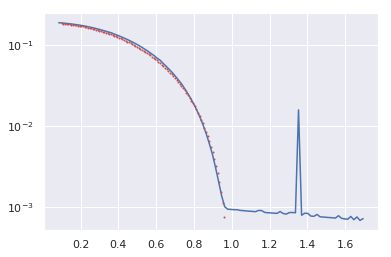

In [492]:
# load data
datafile = './results/rabi_and_lmg_optimizations_20190228/lmg_doublebang_powell.csv'
df = pd.read_csv(datafile, index_col=0)
times = df['tf'] / 1.18
infidelities = 1 - df['fid']
plt.figure();
plt.plot(times, infidelities)
xs = np.linspace(0.1, 0.96, 100)
ys = [0.19 * np.cos(np.pi / 2 * x)**2 for x in xs]
plt.semilogy(xs, ys, 'ro', markersize=1)

In [511]:
datafile = './results/rabi_and_lmg_optimizations_20190228/lmg_doublebang_powell.csv'
df = pd.read_csv(datafile, index_col=0)
data = df.iloc[42]
# df[(df['tf'] > 0.9) & (df['tf'] < 1)]
num_spins = 50
tf = data['tf']
y0 = data['y0']
t1 = data['t1']
y1 = data['y1']
H0 = lmg_model.LMG_free_term(num_spins=num_spins)
H1 = lmg_model.LMG_interaction_term(num_spins=num_spins)

protocol = protocol_ansatz.DoubleBangProtocolAnsatz()
protocol.fill_hyperpar_value(tf=tf)
fun = protocol.time_dependent_fun([y0, t1, y1])
qutip.mesolve(
    H=[H0, [H1, fun]],
    rho0=ground_state(H0),
    tlist=np.linspace(0, tf, 20)
)

DEBUG:root:Initializing ProtocolAnsatz instance "doublebang"
DEBUG:root:Setting hyperparameter tf=0.9060606060606059


Result object with sesolve data.
--------------------------------
states = True
num_collapse = 0

## What happens for different boundaries?

In [617]:
def _():
    # load data
    datafiles = !ls ./results/rabi_and_lmg_optimizations_different_constraints_20190228/rabi*.csv
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=df['fid'],
            mode='markers', name=os.path.split(file)[-1]
        ))
    layout = go.Layout(legend=dict(x=.7, y=0))
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
_()

In [580]:
def _():
    # load data
    datafiles = !ls ./results/rabi_and_lmg_optimizations_different_constraints_20190228/lmg*.csv
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=df['fid'],
            mode='markers', name=os.path.split(file)[-1]
        ))
    layout = go.Layout(legend=dict(x=.7, y=0))
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
_()

## And changing the number of spins in the LMG?

In [216]:
def _():
    # load data
    datafiles = !ls ./results/lmg_different_spinnumbers_20190228/*.csv
    additional_50spins_file = './results/rabi_and_lmg_optimizations_20190228/lmg_doublebang_powell.csv'
    datafiles += [additional_50spins_file]
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=df['fid'],
            mode='markers', name=os.path.split(file)[-1]
        ))
    layout = go.Layout(legend=dict(x=.7, y=0))
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
_()

# LMG optimizations crossing the critical point

## $50$ spins

In [306]:
def _():
    # load data
    datafiles = !ls ./results/rabi_and_lmg_optimizations_crossingcriticalphase_20190305/lmg*50spins*.csv
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=df['fid'],
            mode='markers', name=os.path.split(file)[-1][4:-4]
        ))
    layout = go.Layout(legend=dict(x=.7, y=0), yaxis=dict(range=[0, 1.1]))
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
_()

## $20$ spins

In [210]:
def _():
    # load data
    datafiles = !ls ./results/rabi_and_lmg_optimizations_crossingcriticalphase_20190305/lmg*20spins*.csv
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=df['fid'],
            mode='markers', name=os.path.split(file)[-1][4:-4]
        ))
    layout = go.Layout(
        legend=dict(x=.7, y=0),
        yaxis=dict(range=[0, 1.1])
    )
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
_()

In [201]:
def _():
    # load data
    datafiles = !ls ./results/rabi_and_lmg_optimizations_crossingcriticalphase_20190305/lmg*20spins*.csv
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=1 - df['fid'],
            mode='markers', name=os.path.split(file)[-1][4:-4]
        ))
    layout = go.Layout(
        legend=dict(x=.7, y=0),
#         yaxis=dict(range=[0, 1.1])
        yaxis=dict(type='log', autorange=True)
    )
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
_()

In [ ]:
def _():
    # load data
    datafiles = !ls ./results/rabi_and_lmg_optimizations_crossingcriticalphase_20190305/lmg*20spins*.csv
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=df['fid'],
            mode='markers', name=os.path.split(file)[-1][4:-4]
        ))
    layout = go.Layout(legend=dict(x=.7, y=0), yaxis=dict(range=[0, 1.1]))
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
_()

## Using as target $g=1.5$ instead of $g=2$

In [195]:
def _():
    # load data
    datafiles = !ls ./results/rabi_and_lmg_optimizations_crossingcriticalphase_20190305/optimizations_targetg1.5/*.csv
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=df['fid'],
            mode='markers', name=os.path.split(file)[-1]
        ))
    layout = go.Layout(legend=dict(x=.7, y=0), yaxis=dict(range=[0, 1.1]))
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
_()

In [490]:
def _():
    # load data
    datafiles = !ls ./results/rabi_and_lmg_optimizations_crossingcriticalphase_20190305/optimizations_targetg1.5/*.csv
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=df['fid'],
            mode='markers', name=os.path.split(file)[-1]
        ))
    layout = go.Layout(legend=dict(x=.7, y=0))
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
_()

In [383]:
filename = './results/rabi_and_lmg_optimizations_crossingcriticalphase_20190305/'
filename += 'lmg_doublebang_powell_50spins_bound02_tf20.csv'
df = pd.read_csv(filename, index_col=0)
df[(df['tf'] >= 8.5) & (df['tf'] <= 8.52)]

tf     fid        y0        t1       y1
164  8.515038  0.9802  1.102839  5.188506  1.47825

In [436]:
num_spins=50
tf = 8.515
y0 = 0.35488198 
t1 = 8.1493883
y1 = 26.18875652

out = qutip.mesolve(H=lmg_model.LMG_full_hamiltonian(num_spins=num_spins, g_value=y0),
                    rho0=psi_initial, tlist=np.linspace(0, t1, 10))
out = qutip.mesolve(H=lmg_model.LMG_full_hamiltonian(num_spins=num_spins, g_value=y1),
              rho0=out.states[-1], tlist=np.linspace(t1, tf, 10)).states[-1]
qutip.fidelity(out, psi_target)**2

1.8897561316856466e-06

In [438]:
protocol = protocol_ansatz.DoubleBangProtocolAnsatz()
protocol.fill_hyperpar_value(tf=tf)
fun = protocol.time_dependent_fun([y0, t1, y1])
# plot(fun, np.linspace(0, tf, 50), 'r-o', markersize=4)

foo = qutip.mesolve(
    H=[lmg_model.LMG_free_term(num_spins), [lmg_model.LMG_interaction_term(num_spins), fun]],
    rho0=psi_initial,
    tlist=np.linspace(0, tf, 40)
).states[-1]
qutip.fidelity(foo, psi_target)**2

DEBUG:root:Initializing ProtocolAnsatz instance "doublebang"
DEBUG:root:Setting hyperparameter tf=8.515


1.8922642667563111e-06

In [451]:
num_spins = 50
tf = 8.515

lmg_Hfree = lmg_model.LMG_free_term(num_spins=num_spins)
psi_initial = ground_state(lmg_Hfree)

lmg_Hcritical = lmg_model.LMG_interaction_term(num_spins=num_spins, g_value=1.)
lmg_Htarget = lmg_model.LMG_full_hamiltonian(num_spins=num_spins, g_value=2)
psi_target = ground_state(lmg_Htarget)

protocol = protocol_ansatz.CRABProtocolAnsatz(num_frequencies=4)
protocol.fill_hyperpar_value(tf=tf, y0=0, y1=2)

results = optimization.optimize_model_parameters(
    hamiltonians=[lmg_Hfree, lmg_model.LMG_interaction_term(num_spins=num_spins)],
    initial_state=psi_initial,
    target_state=psi_target,
    protocol=protocol,
    evolution_time=tf,
    optimization_method='Nelder-Mead',
    optimization_options=dict(disp=True, xatol=1e-6, fatol=1e-6, maxiter=1e6, maxfev=1e6),
    initial_parameters=np.random.rand(8)
)

(1 - results.fun)**2

DEBUG:root:Initializing ProtocolAnsatz instance "crab"
DEBUG:root:Initializing CRAB protocol with 4 frequencies
DEBUG:root:Regenerated CRAB frequencies: nuk=[-0.3007889  -0.09501104 -0.47176996 -0.28348321]
DEBUG:root:Setting hyperparameter tf=8.515
DEBUG:root:Setting hyperparameter y0=0
DEBUG:root:Setting hyperparameter y1=2
INFO:root:Starting optimization for tf=8.515
DEBUG:root:Optimization method: Nelder-Mead
DEBUG:root:Optimization options: {'disp': True, 'xatol': 1e-06, 'fatol': 1e-06, 'maxiter': 1000000.0, 'maxfev': 1000000.0}
INFO:root:Initial parameter values: [0.70665387 0.63308529 0.90882086 0.43035783 0.35007918 0.99262459
 0.18430651 0.6852044 ]
INFO:root:Final fidelity: 0.7306481260266581
INFO:root:Final parameters: [ 0.11355634  0.41821674  1.01577629  1.52138773  0.7842983   1.60442262
  0.33265294 -1.1619725 ]


Optimization terminated successfully.
         Current function value: 0.145220
         Iterations: 881
         Function evaluations: 1382


0.7306481260266581

100% (60 of 60) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


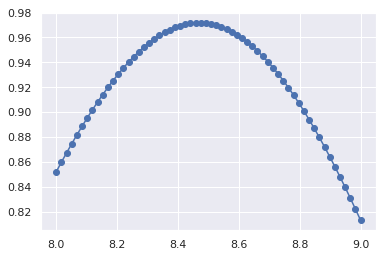

In [397]:
num_spins = 50
lmg_Hfree = lmg_model.LMG_free_term(num_spins=num_spins)
lmg_Htarget = lmg_model.LMG_full_hamiltonian(num_spins=num_spins, g_value=2)
psi_initial = ground_state(lmg_Hfree)
psi_target = ground_state(lmg_Htarget)
t1 = 5.2
tf_list = np.linspace(8, 9, 60)
fids = []
bar = progressbar.ProgressBar()
for tf in bar(tf_list):
    result = qutip.mesolve(H=lmg_model.LMG_full_hamiltonian(num_spins=num_spins, g_value=1.1),
                           rho0=psi_initial, tlist=np.linspace(0, t1, 40))
    result = qutip.mesolve(H=lmg_model.LMG_full_hamiltonian(num_spins=num_spins, g_value=1.5),
                           rho0=result.states[-1], tlist=np.linspace(0, tf - t1, 40))
    fids.append(qutip.fidelity(result.states[-1], psi_target)**2)
plt.figure(); plt.plot(tf_list, fids, '-o')
# fids

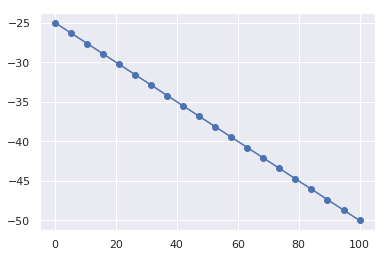

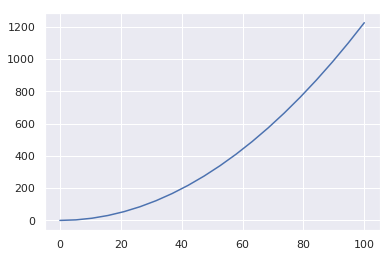

In [251]:
num_spins = 50
g_list = np.linspace(0, 100, 20)
exp_list = []
vars_list = []
for g in g_list:
    Hup = lmg_model.LMG_free_term(num_spins) + lmg_model.LMG_interaction_term(num_spins, g_value=g)
    psi0 = ground_state(lmg_model.LMG_free_term(num_spins))
    exp_list.append(qutip.expect(Hup, psi0))
    vars_list.append(qutip.variance(Hup, psi0))
plt.figure(); plt.plot(g_list, exp_list, '-o')
# plt.figure(); plt.plot(np.log10(g_list), np.log10(vars_list), '-o')
plt.figure(); plt.plot(g_list, vars_list, '-')

# Rabi crossing critical point

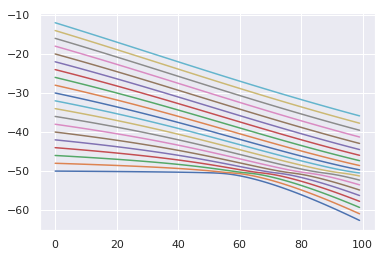

In [577]:
num_spins = 100
g_list = np.linspace(0, 2, 100)
num_eigenvalues = 20
spectrum = np.zeros(shape=(len(g_list), num_eigenvalues))
for idx, g in enumerate(g_list):
    eigvals = lmg_model.LMG_full_hamiltonian(num_spins=num_spins, g_value=g).eigenstates(eigvals=num_eigenvalues)[0]
    spectrum[idx] = eigvals
plt.figure()
plt.plot(spectrum);

In [202]:
filename = './results/rabi_and_lmg_optimizations_crossingcriticalphase_20190305/rabi_doublebang_powell_Omega100_bound20_tf20.csv'
df = pd.read_csv(filename, index_col=0)
df[df['fid'] > 0.5]

In [207]:
Hrabi = rabi_model.RabiModel(N=100, Omega=100, omega_0=1)
eig1, eig2 = Hrabi.hamiltonian(Hrabi.critical_value).eigenenergies(eigvals=2)
np.pi / (eig2 - eig1)

6.019322200965969

In [204]:
def _():
    # load data
    datafiles = !ls ./results/rabi_and_lmg_optimizations_crossingcriticalphase_20190305/rabi*.csv
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=df['fid'],
            mode='markers', name=os.path.split(file)[-1]
        ))
    layout = go.Layout(legend=dict(x=.7, y=0), yaxis=dict(range=[0, 1.1]))
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
_()

# Triplebang

In [212]:
def _():
    # load data
    datafiles = !ls ./results/rabi_and_lmg_optimizations_triplebamg_20190305/*csv
#     additional_50spins_file = './results/rabi_and_lmg_optimizations_20190228/lmg_doublebang_powell.csv'
#     datafiles += [additional_50spins_file]
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=df['fid'],
            mode='markers', name=os.path.split(file)[-1]
        ))
    layout = go.Layout(legend=dict(x=.7, y=0))
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
_()

# LMG doublebang scans

In [53]:
lmg = lmg_model.LMGModel(num_spins=50)
initial_state = ground_state(lmg.H0)
target_state = ground_state(lmg.hamiltonian(g_value=1.))
tf_list = np.linspace(0, 2, 100)
time_ratios_list = np.linspace(0, 1, 100)
bound = [-2, 2]

results = np.zeros(shape=(len(tf_list) * len(time_ratios_list), 3))
bar = progressbar.ProgressBar()
idx = 0
for tf in bar(list(enumerate(tf_list))):
    for ratio in enumerate(time_ratios_list):
        protocol = protocols.DoubleBangProtocolAnsatz()
        protocol.fill_hyperpar_value(tf=tf)
        fun = protocol.time_dependent_fun(np.asarray([bound[1], ratio * tf, bound[0]]))
        output_state = optimization.evolve_state([lmg.H0, [lmg.H1, fun]], initial_state, tf)
        results[idx] = [tf, ratio, qutip.fidelity(output_state, target_state)**2]
        idx += 1
results = pd.DataFrame(results, columns=['tf', 'ratio', 'fid'])

100% (100 of 100) |######################| Elapsed Time: 0:07:38 Time:  0:07:38


# LMG, doublebang, optimal time VS number of spins

In [102]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

optimization.find_best_protocol(
    problem_specification=dict(
        model='lmg', model_parameters=dict(num_spins=50),
        task='critical point state generation'
    ),
    optimization_specs=dict(
        protocol='doublebang',
        optimization_method='powell',
        parameters_constraints=[-2, 2]
    ),
    other_options=dict(
        scan_times=np.arange(0.8, 2, 0.05),
        stopping_condition=0.99
    )
)

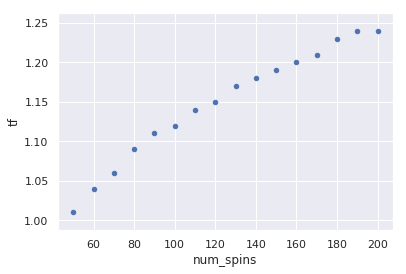

In [134]:
df = pd.read_csv('./results/lmg_timeVSnumspins_analysis/goodTime_vs_numSpins.csv', index_col=0)
df.plot(x='num_spins', y='tf', kind='scatter')

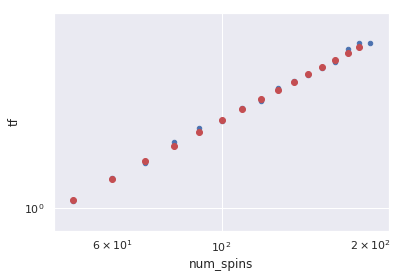

In [153]:
fig, ax = plt.subplots(1, 1)
df.plot(x='num_spins', y='tf', kind='scatter', loglog=True, ax=ax)

xs = np.arange(50, 200, 10)
ys = [np.exp(-0.5718) * x**(0.149) for x in xs]
ax.plot(xs, ys, 'ro')

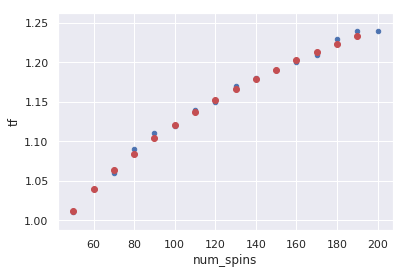

In [154]:
fig, ax = plt.subplots(1, 1)
df.plot(x='num_spins', y='tf', kind='scatter', ax=ax)

xs = np.arange(50, 200, 10)
ys = [np.exp(-0.5718) * x**(0.149) for x in xs]
ax.plot(xs, ys, 'ro')

In [174]:
np.polyfit(x=np.log(df['num_spins']), y=np.log(df['tf']), deg=1, cov=True)

(array([ 0.14918635, -0.57182845]), array([[ 4.64963968e-06, -2.20854758e-05],
        [-2.20854758e-05,  1.05695945e-04]]))

# Landau-Zener tests

In [301]:
def _():
    # load data
    datafiles = !ls ./results/lz_optimizations_20190314/*.csv
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=df['fid'],
            mode='markers', name=os.path.split(file)[-1]
        ))
    layout = go.Layout(legend=dict(x=.7, y=0), yaxis=dict(range=[0, 1.1]))
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
_()

In [305]:
def _():
    # load data
    datafiles = !ls ./results/lz_optimizations_crossing_20190315/*.csv
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=df['fid'],
            mode='markers', name=os.path.split(file)[-1]
        ))
    layout = go.Layout(legend=dict(x=.7, y=0), yaxis=dict(range=[0, 1.1]))
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
_()

2019-03-14 17:11:21,435 [MainThread  ][DEBUG]  Initializing ProtocolAnsatz instance "doublebang"
2019-03-14 17:11:21,436 [MainThread  ][DEBUG]  Setting hyperparameter tf=0.688


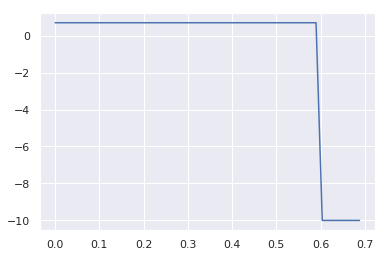

In [284]:
protocol = protocol_ansatz.DoubleBangProtocolAnsatz()
protocol.fill_hyperpar_value(tf=0.688)
protocol.plot([ 0.6966497,   0.59609705, -9.99999974])

In [257]:
qutip.fidelity(
    lz_model.LZModel(omega_0=1).ground_state(-5),
    lz_model.LZModel(omega_0=1).ground_state(0)
)**2

0.5980580675690922

2019-03-14 17:07:51,983 [MainThread  ][DEBUG]  Initializing ProtocolAnsatz instance "crab"
2019-03-14 17:07:51,984 [MainThread  ][DEBUG]  Using 2 frequencies
2019-03-14 17:07:51,986 [MainThread  ][DEBUG]  Regenerated CRAB frequencies: nuk=[0.0133108  0.17020046]
2019-03-14 17:07:51,987 [MainThread  ][DEBUG]  Setting hyperparameter tf=1.0
2019-03-14 17:07:51,989 [MainThread  ][DEBUG]  Setting hyperparameter y0=-2
2019-03-14 17:07:51,990 [MainThread  ][DEBUG]  Setting hyperparameter y1=0
2019-03-14 17:07:51,991 [MainThread  ][DEBUG]  Setting hyperparameter nuk1=0.06945239
2019-03-14 17:07:51,991 [MainThread  ][DEBUG]  Setting hyperparameter nuk2=-0.07438579


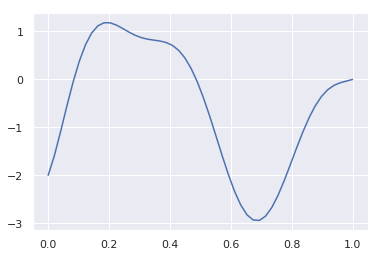

In [282]:
protocol = protocol_ansatz.CRABProtocolAnsatz(num_frequencies=2)
protocol.fill_hyperpar_value(tf=1.0)
protocol.fill_hyperpar_value(y0=-2, y1=0)
freqs = [ 0.06945239, -0.07438579]
protocol.fill_hyperpar_value(nuk1=freqs[0], nuk2=freqs[1])
protocol.plot([163.90725272 ,  0.70841171 , -0.7064373 ,  74.7643606 ])